In [1]:
import os, random
import numpy as np
import torch
import dataset_loader

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Lab exercises 4 - Neural Networks with Pytorch

The goal of this lab exercise is to help you learn how to use Pytorch, one of the most widely used neural network library.

It is important the you read the documentation to understand how to use Pytorch functions, what kind of transformation they apply etc. You have to take time to read it carefully to understand what you are doing.

- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/docs/stable/torch.html

# 1. Pytorch basics

Instead of manipulating numpy arrays, we will manipulate pytorch tensors.
A lot of things are defined in the same way, except the you can use autograd!

Note that when using pytorch and the autograd mechanism, you want to avoid in-place operations, see the example below (in-place operations are important for parameter initialization, but we will skip this in this lab).
It is easy to identify in-place operations: their function name ends with an underscore!

In [2]:
# create a tensor of shape (2, 4) containing random values.
# by default, it will be a float tensor.

t = torch.rand(2, 4)

# you can also create a tensor full of 0 or 1
t_zeros = torch.zeros(2, 4)
t_ones = torch.ones(2, 4)

print(t)
print()
print(t_zeros)
print()
print(t_ones)

tensor([[0.2121, 0.6757, 0.6768, 0.9208],
        [0.4830, 0.2097, 0.5354, 0.5437]])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])


You can access properties of a tensor like its shape or the type of its elements.

In [3]:
t = torch.rand(2, 4)
print("shape of the tensor:", t.shape)
print("type of elements:", t.dtype)

shape of the tensor: torch.Size([2, 4])
type of elements: torch.float32


In [4]:
# you can specify the type of the data contained in the tensor

t = torch.zeros(3, dtype=torch.float32)
t[0] = 1.45

print(t.dtype)
print(t)
print()

t_long = torch.zeros(3, dtype=torch.long)
t_long[0] = 1.45

print(t_long.dtype)
print(t_long)

torch.float32
tensor([1.4500, 0.0000, 0.0000])

torch.int64
tensor([1, 0, 0])


In [5]:
# there also exists *_like functions that creates a tensor with exactly
# the same properties as its argument (shape, type, etc)

t2 = torch.rand_like(t)
t2_zeros = torch.zeros_like(t)
t2_ones = torch.ones_like(t)

print(t2)
print(t2_zeros)
print(t2_ones)

tensor([0.8196, 0.2919, 0.4896])
tensor([0., 0., 0.])
tensor([1., 1., 1.])


In [6]:
# you can also initialize the tensor with values
t_long = torch.LongTensor([0,1,10,20])
print(t_long)

tensor([ 0,  1, 10, 20])


# 2. Gradient computation

Now, let's turn to the serious stuff: gradient computation! :)

When you compute values with Pytorch tensors, the library implicitly builds a computation graph that can be used by the backpropagation algorithm to compute gradients.
However, the graph is build only if there are tensors that have their attribute `requires_grad` set to `True`.
In other word, `t.requires_grad==True` indicates that we want the gradient with respect to this tensor when using the backpropagation algorithm. The gradient will not be computed for tensors for which `requires_grad` is set to `False`.

The backpropagation algorithm can simply be called using the `backward()` method on a tensor (which should be the output tensor, for example the loss value, and usually it should be scalar value).

In [7]:
t = torch.rand(2, 10)

# by default no gradient will be required for t :(
print(t.requires_grad)

# so we ask for it explicitly (note the underscore: in place operation!)
t.requires_grad_(True)
print(t.requires_grad)

# We can also set this to true at creation
t = torch.rand(2, 10, requires_grad=True)
print(t.requires_grad)
print()

# now, let's do a stupid operation and compute the gradient.
# This sum over all element of t,
# it return a tensor with a single value.
z = t.sum()
print("z shape:", z.shape)  # this will look strange!
print("z requires grad?", z.requires_grad)
print()

# backpropagation!
z.backward()

# print the gradient of t,
# it should be a vector full of 1, do you understand why? 
### Parce que dans une somme, chaque terme contribue directement et indépendamment donc
### ∂(t₁ + t₂ + ... + tₙ)/∂tᵢ = 1
print()
print("Gradient:")
print(t.grad)

False
True
True

z shape: torch.Size([])
z requires grad? True


Gradient:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [8]:
# if I call backward a second time, it will accumulate the gradient
# so it will be a tensort full of 2
z.backward()
print(t.grad)
print()

# we can reset the gradient of the tensor to zero
# => note the in-place operation
t.grad.zero_()
print(t.grad)
print()

# and if we backprop again, it will be a tensor full of one again
z.backward()
print(t.grad)

# and this highlight one of the major source of bug in pytorch:
# Do not forget to reset your gradients!

tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


During the lectures, we saw that a neural network library builds a computation graph in order to be able to run the backpropagation algorithm (to compute gradients).
The next examples show how it is stored in pytorch variables.

In the next example, we just sum two values, and then inspect the associated computation graph.


<div class='alert alert-block alert-warning'>
<b>Question:</b>
    Run the code below and compare the result when calling the function grad_fn with argument 1 and argument 2.
    How do you interpret this result?
    What are these values? How are they computed and why?
    What is the argument given to this function?
</div>

In [9]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

c = a + b
# PyTorch crée un graphe de calcul dans lequel c est une opération résultant de AddBackward0, car c’est le résultat de a + b

print("a = %f" % a.item())
print("b = %f" % b.item())
print("c = a + b = %f" % c.item())
print()

# grad_fn est un objet PyTorch représentant l'opération de somme a + b
# une sorte de "fonction fléchée" vers les opérations précédentes dans le graphe
print("The function to call during backward for variable c is:", c.grad_fn)
print()

print("Calling this function with argument 1")
print(c.grad_fn(torch.tensor([1]))) 
print()
"""
C’est la dérivée de c = a + b par rapport à ses inputs, multipliée par le gradient fourni.
Mathématiquement :
    ∂c/∂a = 1
    ∂c/∂b = 1
Donc si tu fais c.grad_fn(torch.tensor([λ])), tu demandes :
    "Si le gradient final est λ, comment ce gradient est-il propagé vers a et b ?"
Et la réponse est : le gradient se propage tel quel, car :
    ∇a = λ × ∂c/∂a = λ × 1 = λ
    ∇b = λ × ∂c/∂b = λ × 1 = λ
"""
print("Calling this function with argument 2")
print(c.grad_fn(torch.tensor([2]))) 
print()

# Ces objets représentent les variables d’origine : a et b.
# Donc c.grad_fn.next_functions te montre quelles fonctions seront appelées ensuite pendant la rétropropagation
print("The next functions that must be called during backpropagation are:")
print(c.grad_fn.next_functions)

a = 0.522551
b = 0.904753
c = a + b = 1.427304

The function to call during backward for variable c is: <AddBackward0 object at 0x7b1536f653c0>

Calling this function with argument 1
(tensor([1]), tensor([1]))

Calling this function with argument 2
(tensor([2]), tensor([2]))

The next functions that must be called during backpropagation are:
((<AccumulateGrad object at 0x7b15360232b0>, 0), (<AccumulateGrad object at 0x7b15369b4c40>, 0))


Next, we do the same computation, but without requiring a gradient for b.

<div class='alert alert-block alert-warning'>
<b>Question:</b> What difference do you notice in the computation graph? How do you explain this?
</div>

In [10]:
a = torch.randn(1, requires_grad=True) # a est une variable différentiable car requires_grad = true
b = torch.randn(1, requires_grad=False) # b est une cste

c = a + b

print("a = %f" % a.item())
print("b = %f" % b.item())
print("c = a + b = %f" % c.item())
print()

# PyTorch génère quand même un graphe car a participe au calcul et nécessite un gradient.
print("The function to call during backward for variable c is :", c.grad_fn)
print()

print("Calling this function with argument 1")
print(c.grad_fn(torch.tensor([1]))) 
print()

# Seul a participe au graphe de calcul puisque b a requires_grad = false
# Donc Pytorch ne suit pas les opérations en amont de b et ne calcule pas de gradient pour lui

print("Calling this function with argument 2")
print(c.grad_fn(torch.tensor([2]))) 
print()

print("The next functions that must be called during backpropagation are:")
print(c.grad_fn.next_functions)

a = -0.022106
b = 0.444223
c = a + b = 0.422117

The function to call during backward for variable c is : <AddBackward0 object at 0x7b1536ddd900>

Calling this function with argument 1
(tensor([1]), None)

Calling this function with argument 2
(tensor([2]), None)

The next functions that must be called during backpropagation are:
((<AccumulateGrad object at 0x7b1648f8b4c0>, 0), (None, 0))


We will now see the impact of in-place operation on the backpropagation algorithm.
In the two following example, we first do a simple operation (addition or multication),
then modify in-place the value of tensor "a", and then call the back propagation algorithm.

<div class='alert alert-block alert-warning'>
<b>Question:</b>
For the addition, modifying "a" in-place does not break the backpropagation algorithm.
When happens for the multiplication? Why?
</div>

In [11]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

c = a + b
# L’addition est linéaire et constante :
    # Le gradient de c = a + b par rapport à a est toujours 1
    # Le fait d’avoir changé la valeur de a n’a aucun impact sur ce gradient
    # PyTorch garde en mémoire la formule de dérivation, pas la valeur courante de a


# the torch.no_grad function can be used to create an environment
# in which no computation graph will be created.
# it is mandatory to modify "leaf" variables that require a gradient.
with torch.no_grad():
    # modify the value of variable "a"
    # [:] is required so the modification is in place,
    # as a = 0 would just make "a" reference the value 0,
    # instead of modifying the tensor referenced by "a"
    a[:] = 0

c.backward()
print(a.grad)
print(b.grad)

tensor([1.])
tensor([1.])


In [12]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

c = a * b
# Le gradient de c = a * b dépend de la valeur de a et de b :
    # ∂c/∂a = b
    # ∂c/∂b = a
# Mais tu as modifié a avant l’appel à backward, donc :
    # Au moment du calcul du gradient, PyTorch voit a = 0, donc il évalue ∂c/∂b = 0
    # Idem pour b → gradient de a est aussi faux

# the torch.no_grad function can be used to create an environment
# in which no computation graph will be created.
# it is mandatory to modify "leaf" variables that require a gradient.
with torch.no_grad():
    # modify the value of variable "a"
    # [:] is required so the modification is in place,
    # as a = 0 would just make "a" reference the value 0,
    # instead of modifying the tensor referenced by "a"
    a[:] = 0

c.backward()
print(a.grad)
print(b.grad)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1]] is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

# 3. First Example : Neural Network for Binary Classification

In this first example, we will build a two neural networks for binary classification:

1. a simple linear classifier, as in the previous lab exercise, but here we will use the autograd mechanism/backpropagation algorithm and all other cool stuff in pytorch to learn the parameters.
2. a multilinear perceptron that learns a non-linear transformation of the data

## 3.1. Linear Model with Pytorch

We must first create the data. We use the same function as in the previous lab exercise.

We will store the data in list of dictionnaries,
each dictionnary is a data point, with two keys:

- `input`: the input tensor
- `label`: the gold output/label

In [13]:
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(mu + res * sigmas)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1], sigmas2=[0.1, 0.1]):
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

X, y = rand_bi_gauss(n1=150, n2=150)

# transform into lists of dictionnaries
separable_binary_data = list()
for i in range(len(y)):
    separable_binary_data.append({
        "input": torch.tensor(X[i], dtype=torch.float32),
        # for the label, we need to convert to the 0/1 format instead of -1/1,
        # moreover, the label must be a long
        "label": torch.tensor((y[i] + 1) // 2, dtype=torch.long)
    })

# split into train/dev/test
separable_binary_data_train = separable_binary_data[:200]
separable_binary_data_dev = separable_binary_data[200:250]
separable_binary_data_test = separable_binary_data[250:]

# show the first training datapoint
print("Example of datapoint:")
print(separable_binary_data_train[0])

Example of datapoint:
{'input': tensor([-0.9427, -1.2048]), 'label': tensor(0)}


### Parameters and Modules

The parameter of your network must be encapsulated in a special class called Parameter: https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
This is very important so that Pytorch knows what are the parameters of the network,
that it must update these parameters when learning, etc.

However, Pytorch comes with a lot of modules already made!
They are in the package torch.nn that we often just rename as nn during import (see the first cell of this notebook).
You can directly use these modules, and therefore you may not need to create and store the parameters of your network yourself.

For exemple, the `nn.Linear` class represent a simple linear projection, including its parameters.
The documentation is available here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [14]:
# create a linear layer that expects an input of dimension 10,
# and returns an output of dimension 20
linear = nn.Linear(10, 20)

# The parameter of the layer are stored
# in attributes weight and bias,
# we can check their type and dimension

print("Type of linear.weight:", type(linear.weight))
print("Type of linear.bias:", type(linear.bias))
print()
print("Shape of linear.weight:", linear.weight.shape)
print("Shape of linear.bias:", linear.bias.shape)
print()
print("Does the parameters require gradient by default?")
print("- weight:", linear.weight.requires_grad)
print("- bias:", linear.weight.requires_grad)

Type of linear.weight: <class 'torch.nn.parameter.Parameter'>
Type of linear.bias: <class 'torch.nn.parameter.Parameter'>

Shape of linear.weight: torch.Size([20, 10])
Shape of linear.bias: torch.Size([20])

Does the parameters require gradient by default?
- weight: True
- bias: True


The `nn.Linear` class is not a subtype of `nn.Parameter`. It is a small neural network module.

Therefore, is must inherit from `nn.Module`, as should all small parts of neural networks

In [15]:
print(type(linear))
print(isinstance(linear, nn.Module))

<class 'torch.nn.modules.linear.Linear'>
True


Pytorch has tons a build-ins neural network components, which are listed here : https://pytorch.org/docs/stable/nn.html

In this lab exercise, I will directly indicate which one you should use!


### Minibatches and Parallel Computation

Modern hardware (CPU and GPU) allows for parallel computation via either multi-threading and SIMD instructions (Single Instruction/Multiple Data).
One of the reasons of the recevent advances in artificial intelligence is the available of high-end GPUs that allows for massive parallel computation.
(Note however that we do not use gamer GPUs for this, a good GPU for machine learning, like a NVIDIA H100 or AMD MI300A, costs ~20.000 euros and you need at least 100 of them to start doing anything serious! and that's only the GPUs :) )

As such, it is very important to parallelize computation to fully use your hardware (even on CPU!).
The simplest form of parallism is parallelizing the forward and backward pass on all the datapoints of your minibatch.
Altough this is far from trivial in the general case,
for the simple examples we will study in this lab exercise,
it is fully transparent: give the full minibatch of data to you neural network, and it will return outputs for all of them.

For example, for a linear model, you can give either:

1. a single datapoint in form of a vector of $d$ elements, where $d$ is the dimension of the input
2. a minibatch of 10 elements, using a matrix of shape $10 \times d$

In [16]:
# just get the two input/output pairs
input1 = separable_binary_data[0]["input"]
input2 = separable_binary_data[1]["input"]

# build a simple linear projection
# input dimension
d = len(input1)

linear = nn.Linear(d, 3)

In [17]:
# compute the output associated with each datapoint
output1 = linear(input1)
output2 = linear(input2)

print(output1)
print(output2)

tensor([-0.5229, -0.3338, -1.3875], grad_fn=<ViewBackward0>)
tensor([-0.5816, -0.3894, -1.2330], grad_fn=<ViewBackward0>)


In [18]:
# concatenate the two inputs into a matrix,
# where each line is one input
all_inputs = torch.cat(
    [input1.reshape(1, -1), input2.reshape(1, -1)],
    dim=0
)

print("input1:", input1)
print("input2:", input2)
print()

print("concatenated inputs:")
print(all_inputs)
print()

print("all_inputs shape:", all_inputs.shape)

# pass both inputs through the linear layer
all_outputs = linear(all_inputs)

print("all_output shape:", all_outputs.shape)
print()

# values must be similar to the case where we passed them one by one!
print(all_outputs)

input1: tensor([-0.9427, -1.2048])
input2: tensor([-0.9500, -0.9432])

concatenated inputs:
tensor([[-0.9427, -1.2048],
        [-0.9500, -0.9432]])

all_inputs shape: torch.Size([2, 2])
all_output shape: torch.Size([2, 3])

tensor([[-0.5229, -0.3338, -1.3875],
        [-0.5816, -0.3894, -1.2330]], grad_fn=<AddmmBackward0>)


### Full Example

We can now build and train a linear classifier with Pytorch.
In the previous lab exercise, we computed the gradient manually, but we also implemented gradient descent manually!

In Pytorch, gradient descent and related methods are provided in the `nn.optim` package.
It contains classes that we called "optimizers", that can do all the work for use.
We will mainly use:

- `nn.optim.SGD`: simple stochastic gradient descent,
- `Adam`: the Adam method (see slides), that works very well in practice.

We need to create an optimizer by indicate the parameters to update (i.e. the parameters of the network) and the learning rate.

But first, 3 functions to simplify the process:

- `build_batch`: takes as input a list datapoints, and concatenate them into a matrix (inputs) and a vector (outputs)
- `eval_binary_classification_network`: evaluate a binary classifier on the given data
- `train_binary_classification_network`: train a binary classifier

Study carefully the code of these functions!

In [19]:
# just a helper function
def build_batch(data):
    batch_inputs = torch.cat(
        [data["input"].reshape(1, -1) for data in data],
        dim=0
    )

    labels = torch.LongTensor([data["label"].reshape(-1) for data in data ])
    
    return batch_inputs, labels

In [20]:
def eval_binary_classification_network(network, data, minibatch_size):
    # pass network in eval mode,
    # i.e. if the dropout module is called,
    # it won't be applied
    network.eval()

    num_correct = 0

    # disable auto-grad as we don't need that during evaluation
    # this speed things a little bit + use less memory
    with torch.no_grad(): 
        for first_element in range(0, len(data), minibatch_size):
            batch_input, labels = build_batch(data[first_element:first_element + minibatch_size])
            logits = network(batch_input)

            # compute the prediction for each datapoint
            prediction = (logits.squeeze(1) >= 0).to(torch.long)
            
            # compare prediction to gold and add to the counter
            num_correct += (prediction == labels).sum().item()

    # the function returns the accuracy
    return 100 * num_correct / len(data)

In [21]:
def train_binary_classification_network(network, optimizer, num_epochs, minibatch_size, train_data, dev_data=None):
    for epoch in range(num_epochs):
        print("Epoch: %i / %i" % (epoch+1, num_epochs))
        
        # shuffle the train data
        # its a good practice to do this at the beginning of each epoch
        random.shuffle(train_data)
        
        # pass the network in training mode,
        # i.e. dropout will be applied if the dropout module is called
        network.train()
    
        # keep track of the whole dataset loss, to print the information at the end of the epoch
        epoch_loss = 0
        for first_element in range(0, len(train_data), minibatch_size):
            # IMPORTANT
            # as gradient is accumulated, we need to set all gradients to 0
            # there are several ways of doing that,
            # the simplest is to call optimizer.zero_grad()
            # that set all parameters tracked by the optimizer to 0
            optimizer.zero_grad()
            
            # build our batched input
            batch_input, labels = build_batch(train_data[first_element:first_element + minibatch_size])
            
            # compute the output weights/logits
            logits = network(batch_input)
            
            # compute the loss
            # the torch.nn.functional packages (renamed as F) contains many
            # useful functions that are not network subpart (neither parameters or modules)
            # https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html
            loss = F.binary_cross_entropy_with_logits(logits.squeeze(1), labels.to(logits.dtype), reduction="sum")
            epoch_loss += loss.item() # it is very important to use .item(), in order to "step-out" from the computation graph
            
            # compute the gradient
            # we take the mean loss
            loss = loss / batch_input.shape[0]
            loss.backward()
    
            # update parameters wrt to gradient information!
            optimizer.step()

        print("- mean loss: %.2f" % (epoch_loss / len(train_data)))

        # at the end of each epoch we evaluate on dev
        if dev_data is not None:
            dev_accuracy = eval_binary_classification_network(network, dev_data, minibatch_size)
            print("- dev acc: %.2f" % dev_accuracy)
        print()

And now, we can create a linear classifier and train it in a few lines of code. :)

In [22]:
# our network is a simple linear projection
network = nn.Linear(2, 1)

# Build the optimizer, i.e. the object that will update parameters
# using the gradient information.
# 
# SGD is standard gradient descent, but there are many alternative!
# https://pytorch.org/docs/stable/optim.html
#
# The first argument of an optimizer is the set of parameters if will update,
# we can use network.parameters() to get all the parameters of our network
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

# Note: this problem is so trivial that you should directly have 100% accuracy on dev
train_binary_classification_network(
    network,
    optimizer,
    3,
    10,
    separable_binary_data_train,
    separable_binary_data_dev
)

Epoch: 1 / 3
- mean loss: 0.50
- dev acc: 100.00

Epoch: 2 / 3
- mean loss: 0.19
- dev acc: 100.00

Epoch: 3 / 3
- mean loss: 0.12
- dev acc: 100.00



## 3.1. Multilinear Perceptron for Binary Classification

In this, the goal is that you build a multilayer perceptron. We will rely on a dataset that is not linearly separable.

### Data

In [23]:
def build_circles_dataset():
    X, y = make_circles(n_samples=400, noise=0.1, factor=0.3, random_state=0)

    data = list()
    for i in range(len(y)):
        data.append({
            "input": torch.tensor(X[i], dtype=torch.float32),
            # for the label, we need to convert to the 0/1 format instead of -1/1,
            # moreover, the label must be a long
            "label": torch.tensor(y[i], dtype=torch.long)
        })
    return data
 

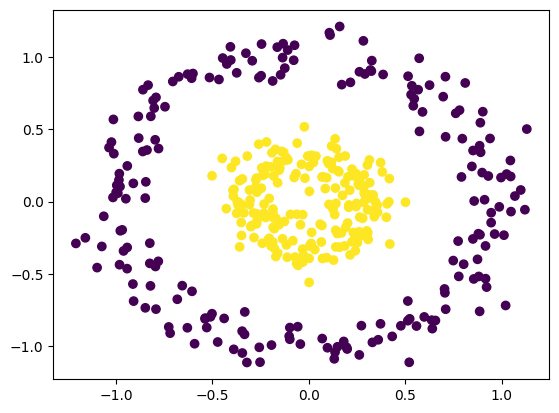

In [24]:
# build the data,
# divide in train/dev/test
# and plot the dataset

circles_data = build_circles_dataset()

circles_data_train = circles_data[:200]
circles_data_dev = circles_data[200:300]
circles_data_test = circles_data[300:]

plt.scatter(
    [d["input"][0].item() for d in circles_data],
    [d["input"][1].item() for d in circles_data],
    c = [d["label"].item() for d in circles_data]
)


### Network

In the previous example, we only used a linear classifier, so it was "easy".
For a more complex neural network like a MLP, we need to create it ourselves in a class. We will create a MLP with two hidden layers and one output layer.

**Constructor:** the constructor must create all parameters and submodules. In our case, we will need three different linear projections.

**forward method:** the forward method takes as input the data, and must return the output of the computation. In our case, these are class weights compute by the network (so you must not compute the loss here, neither apply softmax to transform weights into probabilities).

**Note:** the forward method is never called explicitly, i.e. we never write `network.forward(...)`.
Instead, we treat the object as a function and write `network(...)`, which will implicitly called the `forward` function.

<div class='alert alert-block alert-warning'>
<b>Todo:</b>
Complete the functions `hidden_repr` and `forward` below.
</div>

In the code, we will split the forward pass in the neural network into two functions:

1. the `hidden_repr` function transform the input using the first two linear projections, where each projection is followed by a non-linear activation function. Here we can use the hyperbolic tangen `F.tanh(...)`
2. the `forward` function call hidden_repr to compute the hidden representation, and then apply the output projection.

**Note:** Both function must returns their respective results !

In [25]:
class BinaryClassificationNetwork(nn.Module):
    def __init__(self, input_dim, proj1_dim, proj2_dim):
        super().__init__()
        
        self.proj1 = nn.Linear(input_dim, proj1_dim)
        self.proj2 = nn.Linear(proj1_dim, proj2_dim)
        self.proj3 = nn.Linear(proj2_dim, 1)

    def hidden_repr(self, input_data):
        # TODO: complete this function
        x = torch.tanh(self.proj1(input_data))
        x = torch.tanh(self.proj2(x))
        return x

    def forward(self, input_data):
        # TODO: complete this function
        x = self.hidden_repr(input_data)
        x = self.proj3(x)
        return x
        

We can now train our neural network!

In the code below, compute the hidden representation for all datapoints before and after training, in order to visualize them below.

<div class='alert alert-block alert-warning'>
<b>Todo:</b>
Try different parameter for the training loop: learning rate, number of epochs, minibatch size, etc. What do you observe?
</div>

In [26]:
network = BinaryClassificationNetwork(2, 10, 2)

test_batch_input, test_batch_labels = build_batch(circles_data_test)

with torch.no_grad():
    z_before = network.hidden_repr(test_batch_input)

optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
train_binary_classification_network(network, optimizer, 50, 50, circles_data_train, circles_data_dev)

with torch.no_grad():
    z_after = network.hidden_repr(test_batch_input)

Epoch: 1 / 50
- mean loss: 0.71
- dev acc: 49.00

Epoch: 2 / 50
- mean loss: 0.70
- dev acc: 49.00

Epoch: 3 / 50
- mean loss: 0.69
- dev acc: 53.00

Epoch: 4 / 50
- mean loss: 0.68
- dev acc: 67.00

Epoch: 5 / 50
- mean loss: 0.68
- dev acc: 64.00

Epoch: 6 / 50
- mean loss: 0.68
- dev acc: 65.00

Epoch: 7 / 50
- mean loss: 0.68
- dev acc: 68.00

Epoch: 8 / 50
- mean loss: 0.68
- dev acc: 66.00

Epoch: 9 / 50
- mean loss: 0.67
- dev acc: 63.00

Epoch: 10 / 50
- mean loss: 0.67
- dev acc: 63.00

Epoch: 11 / 50
- mean loss: 0.66
- dev acc: 64.00

Epoch: 12 / 50
- mean loss: 0.65
- dev acc: 64.00

Epoch: 13 / 50
- mean loss: 0.65
- dev acc: 67.00

Epoch: 14 / 50
- mean loss: 0.64
- dev acc: 67.00

Epoch: 15 / 50
- mean loss: 0.63
- dev acc: 68.00

Epoch: 16 / 50
- mean loss: 0.62
- dev acc: 72.00

Epoch: 17 / 50
- mean loss: 0.61
- dev acc: 74.00

Epoch: 18 / 50
- mean loss: 0.59
- dev acc: 74.00

Epoch: 19 / 50
- mean loss: 0.58
- dev acc: 74.00

Epoch: 20 / 50
- mean loss: 0.57
- dev a

### Hidden Representation

The neural network works as follows:

1. project the input using non-linear transformation,
2. use a linear classifier that takes as input the transformed data.

It can do this "end-to-end", and learn the parameters of the non-linear transformation and the linear classsifier at the same time.

<div class='alert alert-block alert-warning'>
<b>Question:</b>
Compare the hidden representation of all datapoints using the two cells below,
    that corresponds to transformed data before and after training.
    What do you observe?
</div>

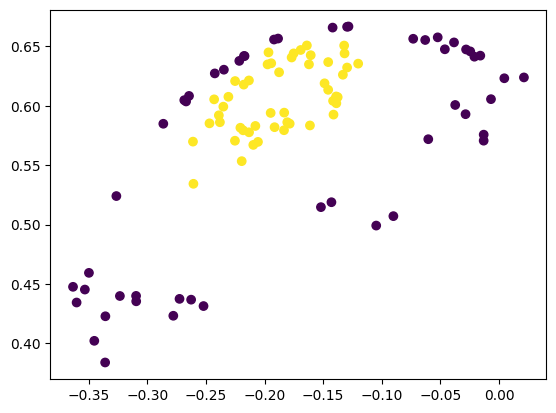

In [27]:
plt.scatter(
    z_before[:, 0],
    z_before[:, 1],
    c=test_batch_labels.tolist()
)

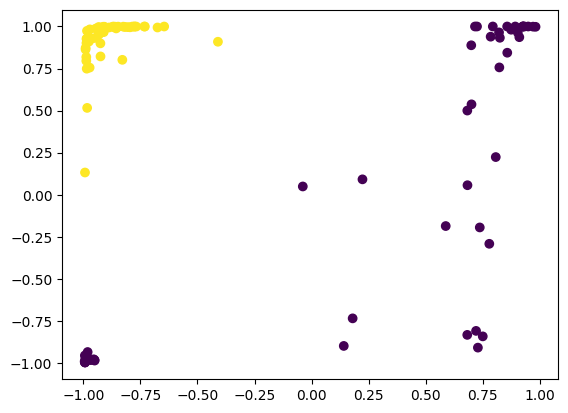

In [28]:
plt.scatter(
    z_after[:, 0],
    z_after[:, 1],
    c=test_batch_labels.tolist()
)

# 4. Multilinear Perceptron for Multiclass Classification

We will now turn to neural networks for multiclass classification.
We will use the MNIST dataset, where the goal is to predict the number written on a picture.

### MNIST data

In [29]:
# read the MNIST dataset

mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

def build_torch_inputs(data):
    x, y = data
    ret = list()
    
    for i in range(x.shape[0]):
        input_tensor = torch.from_numpy(x[i]).reshape(1, -1)
        output_value = torch.tensor([int(y[i])], dtype=torch.long)
        
        ret.append({
            "input": input_tensor,
            "label": output_value
        })
        
    return ret
        
mnist_train = build_torch_inputs(train_data)
mnist_dev = build_torch_inputs(dev_data)
mnist_test = build_torch_inputs(test_data)

In [30]:
# train_data is a list,
# each element is a dictionnary with two keys:
# - input_tensor: the input image as a row vector
# - output_value: the gold label

print(mnist_train[10]["input"].shape)
print(mnist_train[10]["label"])

torch.Size([1, 784])
tensor([4])


label: 6


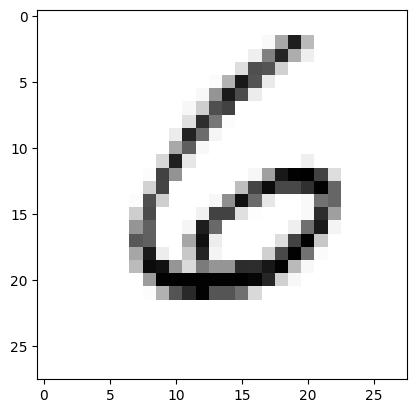

In [31]:
# show an example from the dataset

index = 900
label = mnist_train[index]["label"]
picture = mnist_train[index]["input"]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

### Evaluation and Training Loop

We need to adapt the evaluation and training loop functions for the multiclass classification case.
Comments highlight the difference with the binary case.

In [32]:
def eval_multiclass_classification_network(network, data, minibatch_size):
    network.eval()

    num_correct = 0

    with torch.no_grad(): 
        for first_element in range(0, len(data), minibatch_size):
            batch_input, labels = build_batch(data[first_element:first_element + minibatch_size])
            logits = network(batch_input)

            # compute the prediction for each datapoint
            # contrary to the binary case,
            # here we search for the class of maximum weight
            # dim=-1 means that the class weight dimension is the last dimension
            prediction = logits.argmax(dim=-1)
            
            # compare prediction to gold and add to the counter
            num_correct += (prediction == labels.reshape(-1)).sum().item()

    # the function returns the accuracy
    return 100 * num_correct / len(data)

In [33]:
def train_multiclass_classification_network(network, optimizer, num_epochs, minibatch_size, train_data, dev_data=None):
    for epoch in range(num_epochs):
        print("Epoch: %i / %i" % (epoch+1, num_epochs))
        
        random.shuffle(train_data)
        network.train()
    
        epoch_loss = 0
        for first_element in range(0, len(train_data), minibatch_size):
            optimizer.zero_grad()
            
            batch_input, labels = build_batch(train_data[first_element:first_element + minibatch_size])
            
            logits = network(batch_input)
            
            # compute the loss for multiclass classification.
            # We use the multiclass negative log-likelihood loss,
            # which is implemented by the cross-entropy function.
            # https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
            #
            # (there exists another variant, but which require logit pre-processing, so we use this one instead!)
            loss = F.cross_entropy(logits, labels, reduction="sum")
            epoch_loss += loss.item() # it is very important to use .item(), in order to "step-out" from the computation graph
            
            loss = loss / batch_input.shape[0]
            loss.backward()

            optimizer.step()

        print("- mean loss: %.2f" % (epoch_loss / len(train_data)))

        # at the end of each epoch we evaluate on dev
        if dev_data is not None:
            dev_accuracy = eval_multiclass_classification_network(network, dev_data)
            print("- dev acc: %.2f" % dev_accuracy)
        print()

### Network Definition and Training

You can now complete the code below!
You can try two neural networks:

- LinearMulticlassClassification: a simple linear classifier for multiclass classification
- MLPClassification: a MLP with one hidden layer

<div class='alert alert-block alert-warning'>
<b>Question:</b>
Complete the code of the two neural network. Then, try to train them with different hyperparameters and different optimizers (SGD and Adam). What do you observe?
</div>

In [38]:
class LinearMulticlassClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        # TODO
        # ...
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, input_data):
        # TODO
        # ...
        return self.linear(input_data)


In [39]:
network = LinearMulticlassClassifier(mnist_train[0]["input"].shape[-1], 10)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

train_multiclass_classification_network(
    network,
    optimizer,
    10,
    50,
    mnist_train,
    mnist_dev
)

Epoch: 1 / 10
- mean loss: 0.55


TypeError: eval_multiclass_classification_network() missing 1 required positional argument: 'minibatch_size'

In [40]:
class MLPMulticlassClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size, num_classes):
        super().__init__()

        # TODO
        # ...
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_data):
        
        # TODO
        # ...
        hidden = F.relu(self.hidden(input_data))
        return self.output(hidden)
        

In [41]:
network = MLPMulticlassClassifier(mnist_train[0]["input"].shape[-1], 100, 10)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

train_multiclass_classification_network(
    network,
    optimizer,
    10,
    50,
    mnist_train,
    mnist_dev
)

NameError: name 'hidden_dim' is not defined

# 5. Next Steps!

Now that you know how to build a basic model, there are many things you can do!
You will find below a list of modification you can explore.
The most important one is dropout, but after that you are free to explore them in any order.


<div class='alert alert-block alert-warning'>
<b>TODO:</b>
Read until the end, and then implement a neural network with dropout and train it.
    Then, if you have time, you can implement the other topics discussed here.
</div>

### Regularization and Gradient Clipping

You can try two types of regularization (they can be combined together):

- weight decay: it is a parameter of the optimizer
- dropout

For dropout, you need to create a dropout layer as part of your network. :)
It will be automatically enabled/disabled when you call network.train()/.eval().

https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

In [42]:
# This code allows you to observe how dropout works

t = torch.ones(2, 4)
print("initial tensor")
print(t)
print()


dropout = nn.Dropout(0.5)

# activate train mode
dropout.train()
t2 = dropout(t)

print("tensor after applying dropout (in train mode)")
print(t2)
print()



print("tensor after applying dropout (in eval mode)")
dropout.eval()
t3 = dropout(t)
print(t3)

# WARNING => of course you don't need to directly call train()/eval() on the dropout object in practice,
# but instead you call the one of the network that will recursively call it to all
# its module attributes!

initial tensor
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])

tensor after applying dropout (in train mode)
tensor([[2., 2., 0., 0.],
        [0., 2., 0., 2.]])

tensor after applying dropout (in eval mode)
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]])


Another commong trick for training neural networks is gradient clipping: if the norm of the gradient is too big, we rescale the gradient. This trick can be used to prevent exploding gradients and also to make "too big steps" in the wrong direction due the use of approximate gradient computation in stochastic gradient descent.

In [43]:
batch_loss.backward()  # compute gradient
torch.nn.utils.clip_grad_value_(network.parameters(), 5.)  # clip gradient if its norm exceed 5
optimizer.step()  # update parameters

NameError: name 'batch_loss' is not defined

### Module Lists and Sequential Modules

Sometimes, you need to have a list of submodules.
In this very important to never store them in "raw" Python list, **you should never do** something like this in you network construction:

```
self.modules = list()
self.modules.append(nn.Linear(10, 20)
self.modules.append(nn.Linear(20, 20)
```

The reason is that Pytorch must know which attributes corresponds to neural network parts/submodules.
If you use a Python list, Pytorch will not see them.
Instead, you can use a `nn.ModuleList()` object:

```
self.modules = nn.ModuleList()
self.modules.append(nn.Linear(10, 20)
self.modules.append(nn.Linear(20, 20)
```

See the documentation: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html

Similar classes exists for dictionnaries, etc.


Another useful submodule container is nn.Sequential(): https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

The idea behind a Sequential() object is that it is a list of sub-modules. When you call the object, it will just execute one module after the other, passing as input of the next one the result of the previous one.

Here is an example on how to use this to construct a single projection with non-linearity and dropout:

In [44]:
# Example of usage: we define a projection as a Sequential object
seq = nn.Sequential(
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Dropout(0.5)  
)

# batched input
inputs = torch.rand(3, 10)

# will call successively the 3 subnetworks,
# i.e. it will apply linear transformation,
# then relu and then dropout
outputs = seq(inputs)
print(outputs.shape)

torch.Size([3, 5])


Unfortunately, it is a little bit more difficult to create than nn.Sequential() because it doesn't have an append() method... but you can use list comprehension + transform the list as a sequence of argument to the constructor.

In [45]:
# the list is a single argument
print([1, 2, 3])

# here we call print with 3 different arguments,
# notice how the output is different
print(1, 2, 3)

# so, how do we call a function by passing the values
# from a list as separate argument?
# Well, like this:
print(*[1, 2, 3])

# notive that this last output is similar to the second one,
# and different from the first! :)

[1, 2, 3]
1 2 3
1 2 3
